In [172]:
# financial data analysis with arhmm

In [173]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

In [174]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import seaborn as sns

from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation

import numpy as np
import pandas as pd

In [175]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink"
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

### loading the dataset

False
False


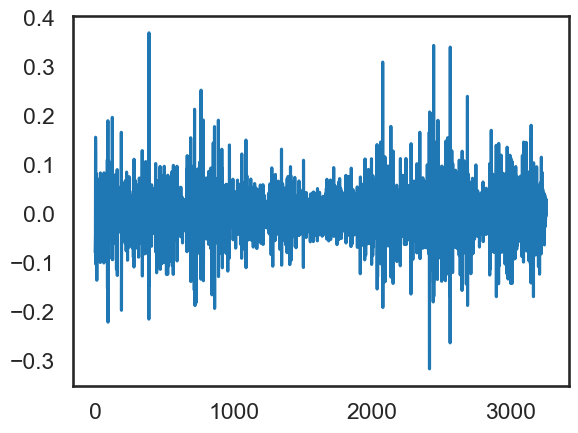

In [176]:
data = pd.read_csv("Financial-Data/stocks/TSLA.csv")
data = data.dropna()
data.head()

close_diff = np.diff(np.log(data['Close']))[1:]
close_diff_1 = np.diff(np.log(data['Close']), n=2)

has_nan_close_diff = np.any(np.isnan(close_diff))
has_nan_close_diff_1 = np.any(np.isnan(close_diff_1))

print(has_nan_close_diff)
print(has_nan_close_diff_1)

plt.plot(close_diff_1)

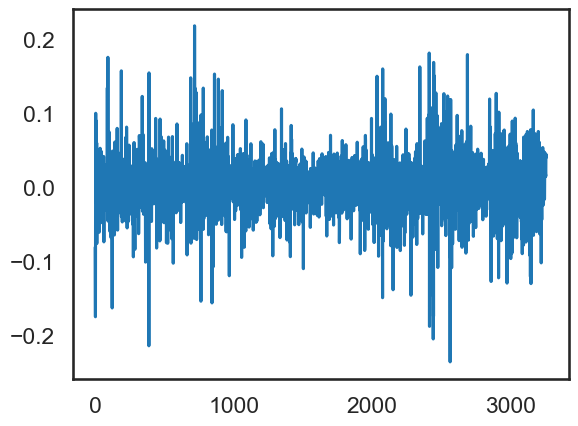

In [177]:
plt.plot(close_diff)

## fitting a model

In [178]:
# Now fit an HMM to the emissions
key1, key2 = jr.split(jr.PRNGKey(0), 2)
num_states = 3
emission_dim = 1
num_lags = 1
start_index = 2400
emissions = jnp.array(close_diff[start_index:]).reshape(-1, 1)
time_bins = len(emissions)


# Initialize with K-Means
arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
params, props = arhmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=emissions)

inputs = arhmm.compute_inputs(emissions)

# Fit with EM
fitted_params, lps = arhmm.fit_em(params, props, emissions, inputs=inputs)

/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Plot the log-likelihood

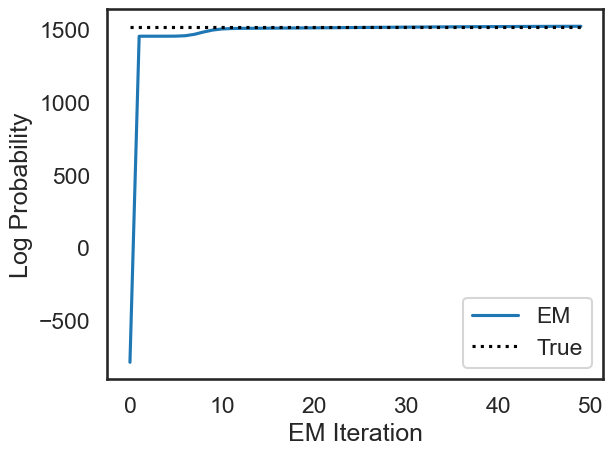

In [179]:
true_lp = arhmm.marginal_log_prob(fitted_params, emissions, inputs=inputs)
plt.plot(lps, label="EM")
plt.plot(true_lp * jnp.ones(len(lps)), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

## inspecting the parameters

In [180]:
# inspecitng the fitted parameters
for i in range(len(fitted_params)):
    print(fitted_params[i])

ParamsStandardHMMInitialState(probs=Array([0.09752204, 0.7602546 , 0.14222325], dtype=float32))
ParamsStandardHMMTransitions(transition_matrix=Array([[0.89545935, 0.07769316, 0.02684752],
       [0.01964727, 0.39659646, 0.5837563 ],
       [0.04369641, 0.89502484, 0.06127877]], dtype=float32))
ParamsLinearRegressionHMMEmissions(weights=Array([[[ 0.00694419]],

       [[-0.11154519]],

       [[ 0.2207518 ]]], dtype=float32), biases=Array([[ 0.00554095],
       [ 0.00460344],
       [-0.00500921]], dtype=float32), covs=Array([[[0.00487516]],

       [[0.00056989]],

       [[0.00204868]]], dtype=float32))


# find most likely states

In [181]:
posterior = arhmm.smoother(fitted_params, emissions, inputs=inputs)
most_likely_states = arhmm.most_likely_states(fitted_params, emissions, inputs=inputs)

# sample new data and plot them

(858, 1)


Text(0, 0.5, 'Emissions')

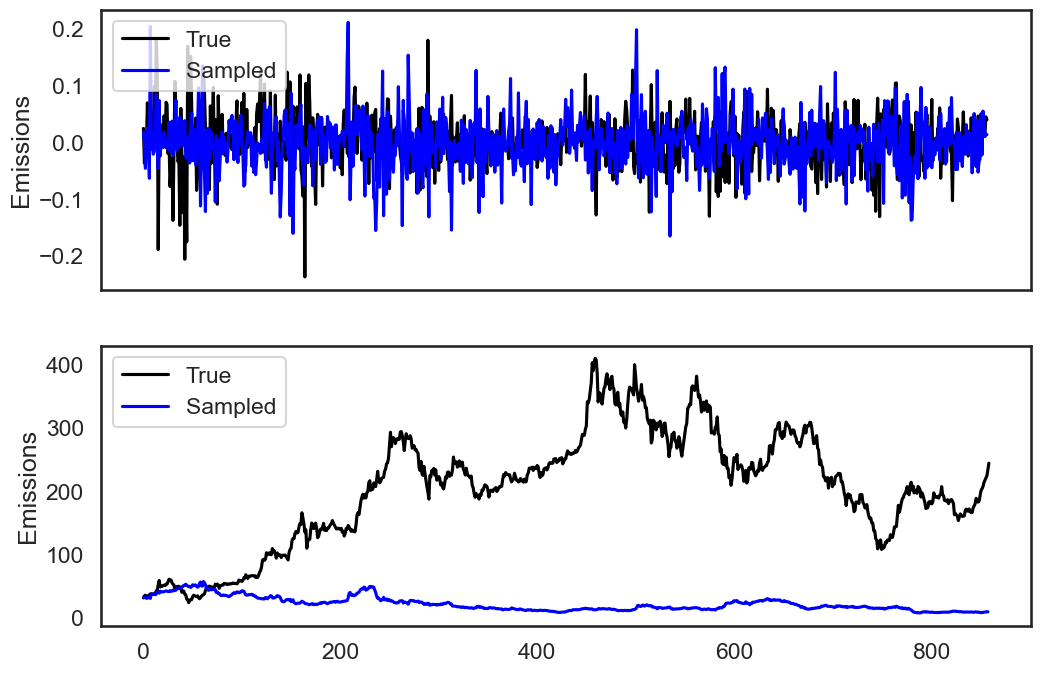

In [182]:
sampled_states, sampled_emissions = arhmm.sample(fitted_params, jr.PRNGKey(0), time_bins)

print(sampled_emissions.shape)

initial_value = data['Close'].iloc[start_index]
recovered_log = np.cumsum(np.concatenate(([np.log(initial_value)], sampled_emissions.reshape(-1))))
recovered_series = np.exp(recovered_log)

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(emissions, color="black", label="True")
ax[0].plot(sampled_emissions, color="blue", label="Sampled")
ax[0].legend(loc="upper left")
ax[0].set_ylabel("Emissions")

d = data['Close'][start_index:].to_numpy()
ax[1].plot(d, color="black", label="True")
ax[1].plot(recovered_series, color="blue", label="Sampled")
ax[1].legend(loc="upper left")
ax[1].set_ylabel("Emissions")

In [183]:
initial_value = 0
start = [1,2,3,1,4,5,3,7,4]
converted = np.diff(np.log(start))
print(converted)
recovered_log = np.cumsum(np.concatenate(([np.log(start[0])], converted)))
recovered_series = np.exp(recovered_log)
print(recovered_series)

[ 0.69314718  0.40546511 -1.09861229  1.38629436  0.22314355 -0.51082562
  0.84729786 -0.55961579]
[1. 2. 3. 1. 4. 5. 3. 7. 4.]


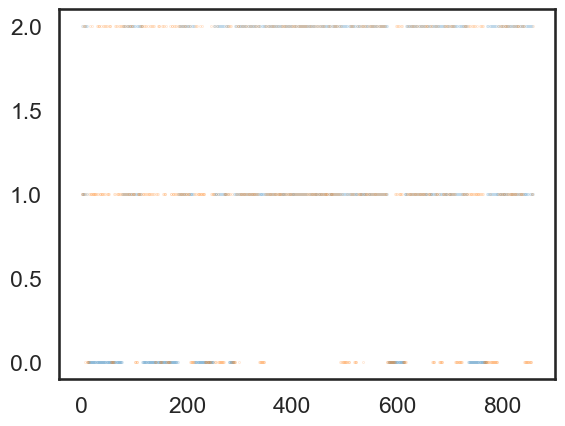

In [184]:
plt.scatter(np.arange(len(most_likely_states)),most_likely_states, s=0.01)

plt.scatter(np.arange(len(most_likely_states)),sampled_states, s=0.01)


(array([250., 326., 282.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

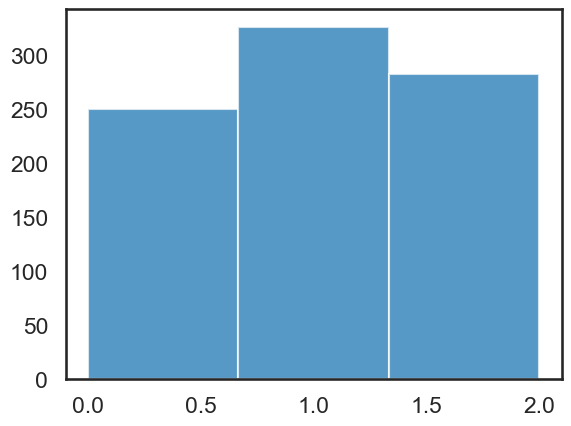

In [185]:
plt.hist(most_likely_states, bins=num_states, alpha=0.75)

Text(0.5, 0, 'time')

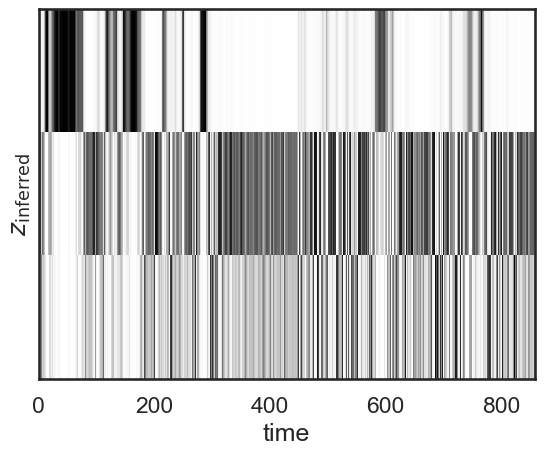

In [186]:
plot_slice = (0, time_bins)
plt.imshow(posterior.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

In [187]:
print(posterior.smoothed_probs)

[[0.02652416 0.8881604  0.08531546]
 [0.03120326 0.37953463 0.5892621 ]
 [0.04025373 0.6867625  0.27298382]
 ...
 [0.02895395 0.69197154 0.27907455]
 [0.056964   0.5045942  0.43844184]
 [0.08345085 0.52419424 0.39235494]]
